In [1]:
import torch
import torchvision
# from torch.utils.tensorboard import SummaryWriter
import time
from torch import nn
from torch.utils.data import DataLoader
from load_data import MyData  # self-made
from torchvision import transforms
from tqdm import tqdm_notebook as tqdm # View procedure
import os
import scipy.io
from random import random
import numpy as np
import gc
from torch.utils.tensorboard import SummaryWriter
from net_cnn_lstm1 import MyNetwork
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_curve, auc
import torch.nn.functional as F
import pandas as pd

# Load Test Data

In [26]:
mode_list = ['hc_doc', 'mcs_uws']
# exper_dir = "rest"
exper_dir = "rest59"
# ================================================ check this for every run
mode = mode_list[0]
# ================================================
root_dir = f"../data/eegmap_split/{exper_dir}"
test_data = []
test_label = []
# ---- hc
if mode == mode_list[0]:
    dataset = MyData(root_dir, f"test", "hc") # hc
    # find the fold file
    for person in range(len(dataset)):
        filename = os.path.join(dataset.path, dataset.file_path[person])
        data_map = torch.load(filename)
#         print(f"data_map size: {data_map.size()}")
        # extract the pure name of the file
        parts = filename.split("\\")
        file_name = parts[-1]
        name_without_extension = file_name.split(".")[0]
        # label or data
        file_last = name_without_extension.split("_")[-1]
        file_last_second = name_without_extension.split("_")[-2]
        if file_last == "label": # label
            for label in data_map:
                if (mode == mode_list[0] and file_last_second == 'doc') or (mode == mode_list[1] and file_last_second == 'uws'):
                    test_label.append(label)
        else: # data
            for data in data_map:
                test_data.append(data)
        del filename, parts, name_without_extension, file_last
        gc.collect()
        torch.cuda.empty_cache()   
# ---- mcs
dataset = MyData(root_dir, "test", "mcs") 
# find the fold file
for person in range(len(dataset)):
    filename = os.path.join(dataset.path, dataset.file_path[person])
    data_map = torch.load(filename)
#     print(f"data_map size: {data_map.size()}")
    # extract the pure name of the file
    parts = filename.split("\\")
    file_name = parts[-1]
    name_without_extension = file_name.split(".")[0]
    # label or data
    file_last = name_without_extension.split("_")[-1]
    file_last_second = name_without_extension.split("_")[-2]
    if file_last == "label": # label
        for label in data_map:
            if (mode == mode_list[0] and file_last_second == 'doc') or (mode == mode_list[1] and file_last_second == 'uws'):
                test_label.append(label)
    else: # data
        for data in data_map:
            test_data.append(data)
    del filename, parts, name_without_extension, file_last
    gc.collect()
    torch.cuda.empty_cache()  
# ---- uws
dataset = MyData(root_dir, "test", "uws") # uws
# find the fold file
for person in range(len(dataset)):
    filename = os.path.join(dataset.path, dataset.file_path[person])
    data_map = torch.load(filename)
#     print(f"data_map size: {data_map.size()}")
    # extract the pure name of the file
    parts = filename.split("\\")
    file_name = parts[-1]
    name_without_extension = file_name.split(".")[0]
    # label or data
    file_last = name_without_extension.split("_")[-1]
    file_last_second = name_without_extension.split("_")[-2]
    if file_last == "label": # label
        for label in data_map:
            if (mode == mode_list[0] and file_last_second == 'doc') or (mode == mode_list[1] and file_last_second == 'uws'):
                test_label.append(label)
    else: # data
        for data in data_map:
            test_data.append(data)
    del filename, parts, name_without_extension, file_last
    gc.collect()
    torch.cuda.empty_cache()  
test_data = torch.stack(test_data)
test_label = torch.stack(test_label)
print(test_data.size())
print(test_label.size())
test_data_size = test_label.size()

torch.Size([2770, 2400, 59, 1])
torch.Size([2770])


In [27]:
BATCH_SIZE = 1
C,H,W = 1,1,2400
learn_rate = 0.001
num_epochs = 60

In [28]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
# test dataset
test_td = TensorDataset(test_data, test_label)
test_loader = DataLoader(test_td, batch_size = BATCH_SIZE, shuffle = True)

In [29]:
del test_data
del test_label
del test_td
gc.collect()
torch.cuda.empty_cache()

# 设置随机种子

In [30]:
import random
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
manualSeed = 32
random.seed(manualSeed)
torch.manual_seed(manualSeed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(manualSeed)

# Load Model

model_index: 5
model_name:_6
../models/hc_doc/rest59_6_2
epoch list: [35, 35, 37, 34, 30]


D:\Anaconda\envs\pytorch\lib\site-packages\ipykernel_launcher.py:165: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/5 [00:00<?, ?it/s]

=====================Epoch 35 == Loss:159.26573009555676===============
--ACC: 0.9902527075812274
--PPV: 0.9901605385810461
--SPE: 0.9776470588235294
--SEN: 0.9958333333333333
=====================Epoch 35 == Loss:139.88671649154568===============
--ACC: 0.9945848375451264
--PPV: 0.9953198127925117
--SPE: 0.9894117647058823
--SEN: 0.996875
=====================Epoch 37 == Loss:1187.2139661770757===============
--ACC: 0.9667870036101083
--PPV: 0.954726368159204
--SPE: 0.8929411764705882
--SEN: 0.9994791666666667
=====================Epoch 34 == Loss:258.6603459841463===============
--ACC: 0.9916967509025271
--PPV: 0.9896747547754259
--SPE: 0.9764705882352941
--SEN: 0.9984375
=====================Epoch 30 == Loss:291.5121999231597===============
--ACC: 0.9711191335740073
--PPV: 0.9983748645720477
--SPE: 0.9964705882352941
--SEN: 0.9598958333333333
================final results====================
test_count_all: 13850
TP_all: 9505
TN_all: 4108
FP_all: 142
FN_all: 95
--ACC_all: 0.98288808

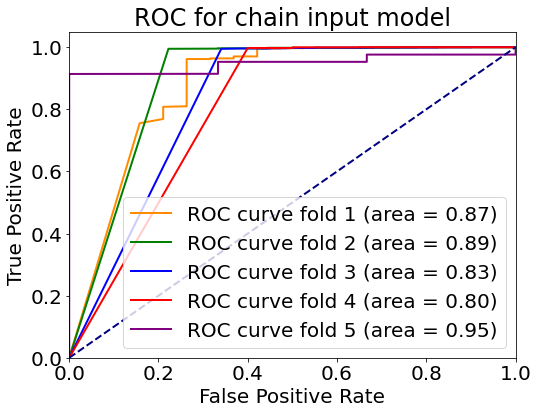

In [31]:
import torch.optim as optim
device = torch.device("cuda:0")
gc.collect()
torch.cuda.empty_cache()
# 加载预训练模型!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# 定义LSTM超参数
input_size = 64  # 输入特征维度
hidden_size = 64  # 隐藏单元数量
num_layers = 2  # LSTM层数
output_size = 2  # 输出类别数量

# ==损失函数权重
# # condition3-HC/DOC
# total_samples = 887 + 975 + 879
# weights = [total_samples / 887, total_samples / (975 + 879)]
# condition3-MCS/UWS
# total_samples = 975 + 879
# weights = [total_samples / 975, total_samples / 879]

# =============================================== check this for every run
# === rest - HC/DOC
if mode == mode_list[0]:
    total_samples = 852 + 1051 + 872
    weights = [total_samples / 852, total_samples / (1051 + 872)]
# === rest - MCS/UWS
elif mode == mode_list[1]:
    total_samples = 1051 + 872
    weights = [total_samples / 1051, total_samples / 872]
# =========================================================================

# 将权重转换为张量
weights_tensor = torch.tensor(weights, device=device)
# 定义交叉熵损失函数并设置权重
criterion = nn.CrossEntropyLoss(weight=weights_tensor)
criterion = criterion.to(device)
# 将权重转换为张量
weights_tensor = torch.tensor(weights, device=device)
# 定义交叉熵损失函数并设置权重
criterion = nn.CrossEntropyLoss(weight=weights_tensor)
criterion = criterion.to(device)

# =============================================== check this for every run
model_list = ['_1', '_2', '_3', '_4','_5','_6','_7','_8','_9','_10','_11']
# model_index = [0,3,6,10,9,7,8,1]
# model_index = [1]
model_index = [5] # chain input
# model_list = ['_1', '_4', '_7', '_11', '_10', '_8', '_9', '_2']
# =========================================================================
for index in model_index:
    print(f"model_index: {index}")
    model_name = model_list[index]
    print(f"model_name:{model_name}")
    if model_name == model_list[0]: 
        from net_cnn_lstm1 import MyNetwork
    elif model_name == model_list[1]: 
        from net_cnn_lstm2 import MyNetwork
    elif model_name == model_list[2]: 
        from net_cnn_lstm3 import MyNetwork
    elif model_name == model_list[3]: 
        from net_cnn_lstm4 import MyNetwork
    elif model_name == model_list[4]: 
        from net_cnn_lstm5 import MyNetwork
    elif model_name == model_list[5]: 
        from net_cnn_lstm6 import MyNetwork
    elif model_name == model_list[6]: 
        from net_cnn_lstm7 import MyNetwork
    elif model_name == model_list[7]: 
        from net_cnn_lstm8 import MyNetwork
    elif model_name == model_list[8]: 
        from net_cnn_lstm9 import MyNetwork
    elif model_name == model_list[9]: 
        from net_cnn_lstm10 import MyNetwork
    elif model_name == model_list[10]: 
        from net_cnn_lstm11 import MyNetwork
    model = MyNetwork(input_size, hidden_size, num_layers, output_size)
    model = model.to(device)

    # fold = 0
    # begin = 0
    # end = 56
    
    # =============================================== check this for every run
    classification = mode
    if model_name == model_list[5]: 
        exper_dir = "rest59"
        trial='_2'
    else:
        exper_dir = "rest"
        trial=''
    # =========================================================================
    print(f"../models/{classification}/{exper_dir}{model_name}{trial}")

    # =============================================== check this for every run
    # CNN+LSTM
    # rest - HC/DOC - model1
    if mode == mode_list[0]:
        # model_1
        if model_name == model_list[0]:
            epoch_list = [15,13,23,16,19]
        # model_4
        elif model_name == model_list[3]:
            epoch_list = [17,15,17,15,11]
        # model_7
        elif model_name == model_list[6]:
            epoch_list = [17,17,13,17,17]
        # model_11
        elif model_name == model_list[10]:
            epoch_list = [23,17,14,14,13]
        # model_10
        elif model_name == model_list[9]:
            epoch_list = [18,14,19,23,14]
        # model_8
        elif model_name == model_list[7]:
            epoch_list = [16,17,15,13,15]
        # model_9
        elif model_name == model_list[8]:
            epoch_list = [16,17,15,13,15]
        # model_2
        elif model_name == model_list[1]:
            epoch_list = [22,19,18,13,14]
        # chain input
        elif model_name == model_list[5]: 
            epoch_list = [35,35,37,34,30]
    elif mode == mode_list[1]:
        # rest - MCS/UWS - model1
        if model_name == model_list[0]:
            epoch_list = [36,27,33,32,23]
        elif model_name == model_list[1]:
            epoch_list = [30,34,20,29,22]
        elif model_name == model_list[3]:
            epoch_list = [27,36,37,31,25]
        elif model_name == model_list[6]:
            epoch_list = [26,41,26,21,31]
        elif model_name == model_list[10]:
            epoch_list = [33,19,28,19,37]
        elif model_name == model_list[9]:
            epoch_list = [26,23,37,36,29]
        elif model_name == model_list[7]:
            epoch_list = [20,22,32,18,15]
        elif model_name == model_list[8]:
            epoch_list = [39,22,34,36,35]
        elif model_name == model_list[5]: # chain input
            epoch_list = [40,44,47,44,41]
    print(f"epoch list: {epoch_list}")
    # Linked input
    # HC/DOC - model12
    # epoch_list = [35,35,37,34,30]
    # MCS/UWS - model12
    # epoch_list = [40,44,47,44,41]
    # =========================================================================
    test_count_all = 0
    TP_all = 0
    TN_all = 0
    FP_all = 0
    FN_all = 0
    # # 用于绘制混淆矩阵
    predicted_labels_list = []
    true_probs_list = []
    true_labels_list = []
    predicted_labels_all = torch.tensor([])
    predicted_labels_all = predicted_labels_all.to(device)
    true_labels_all = torch.tensor([])
    true_labels_all = true_labels_all.to(device)
    sum = 0
    for fold in tqdm(range(5)):
        sum += 1
        # 用于绘制混淆矩阵
        predicted_labels = torch.tensor([])
        predicted_labels = predicted_labels.to(device)
        true_labels = torch.tensor([])
        true_probs = torch.tensor([])
        true_probs = true_probs.to(device)
        true_labels = true_labels.to(device)
    #     for i in tqdm(range(begin,end)):
        model = MyNetwork(input_size, hidden_size, num_layers, output_size)
        model.load_state_dict(torch.load(f"../models/{classification}/{exper_dir}{model_name}{trial}/Fold{fold}_Epoch{epoch_list[fold]}.pt"))
        model = model.to(device)
        # 测试步骤开始
        model.eval()
        # 初始化损失和准确率
        TP = 0
        TN = 0
        FP = 0
        FN = 0
        total_test_loss = 0
        # 计数
        test_count = 0
    #     # 用于绘制混淆矩阵
    #     predicted_labels = torch.tensor([])
    #     predicted_labels = predicted_labels.to(device)
    #     true_labels = torch.tensor([])
    #     true_labels = true_labels.to(device)
        with torch.no_grad(): # 设置不进行后向传播
            for data in test_loader:
                test_count = test_count + 1
                data_map, label=data # x,y
                # x
                if model_name == model_list[5]:
                    data_map_reshaped = torch.reshape(data_map, (59, 1, 1, 2400))
                else:
                    data_map_reshaped = torch.reshape(data_map, (110, 1, 1, 2400))
                data_map_reshaped = data_map_reshaped.to(device)
                # y
                label_int = label.long()
                label_int = label_int.to(device)
                # clear gpu
                del data_map
                del label
                gc.collect()
                torch.cuda.empty_cache()
                # y_pred
                label_pred_test = model(data_map_reshaped)
                softmax_pred = F.softmax(label_pred_test, dim=1)
                # confusion matrix
                predicted_labels_all = torch.cat((predicted_labels_all, label_pred_test.argmax(1)), dim=0)
                true_labels_all = torch.cat((true_labels_all, label_int), dim=0)
#                 true_probs = torch.cat((true_probs, softmax_pred.max().unsqueeze(0)), dim=0)
                predicted_labels = torch.cat((predicted_labels, label_pred_test.argmax(1)), dim=0)
#                 true_labels = torch.cat((true_labels, label_int), dim=0)
                # loss
                loss = criterion(label_pred_test,label_int)
                total_test_loss = total_test_loss + loss.item()

                pred_label = ((label_pred_test.argmax(1)) == label_int).sum()
                pred_prob = label_pred_test.max()
                # calculation
                if label_int == 1: # DOC
                    if pred_label == 1: # 预测对了
                        TP = TP + 1
                    elif pred_label ==0: # 预测错了
                        FN = FN + 1
                if label_int == 0: # HC
                    if pred_label == 1: # 预测对了
                        TN = TN + 1
                    elif pred_label == 0: # 预测错了
                        FP = FP + 1
                if label_int == pred_label:
                    true_probs = torch.cat((true_probs, softmax_pred.max().unsqueeze(0)), dim=0)
                    true_labels = torch.cat((true_labels, label_int), dim=0)
        predicted_labels_list.append(predicted_labels)
        true_probs_list.append(true_probs)
        true_labels_list.append(true_labels)
        print(f"=====================Epoch {epoch_list[fold]} == Loss:{total_test_loss}===============")
        print(f"--ACC: {(TP + TN) / (TP + TN + FP + FN)}")
        print(f"--PPV: {TP / (TP + FP)}")
        print(f"--SPE: {TN / (TN + FP)}")
        print(f"--SEN: {TP / (TP + FN)}")
        test_count_all += test_count
        TP_all += TP
        TN_all += TN
        FP_all += FP
        FN_all += FN
        del model,TP,TN,FP,FN,total_test_loss,test_count
        gc.collect()
        torch.cuda.empty_cache()
    print(f"================final results====================")
    print(f"test_count_all: {test_count_all}")
    print(f"TP_all: {TP_all}")
    print(f"TN_all: {TN_all}")
    print(f"FP_all: {FP_all}")
    print(f"FN_all: {FN_all}")
    print(f"--ACC_all: {(TP_all + TN_all) / (TP_all + TN_all + FP_all + FN_all)}")
    print(f"--PPV_all: {TP_all / (TP_all + FP_all)}")
    print(f"--SPE_all: {TN_all / (TN_all + FP_all)}")
    print(f"--SEN_all: {TP_all / (TP_all + FN_all)}")
    
    

    # 设置全局字体大小
    plt.rcParams.update({'font.size': 20})  # 设置字体大小为 14
    plt.figure(figsize=(8, 6))
    colors = ['darkorange', 'green', 'blue', 'red', 'purple']
    all_roc_data = []
    for fold in range(5):
#         predicted_labels_fold = predicted_labels_list[fold].cpu().numpy()
        true_labels_fold = true_labels_list[fold].cpu().numpy()
        true_probs_fold = true_probs_list[fold].cpu().numpy()
        fpr, tpr, _ = roc_curve(true_labels_fold, true_probs_fold)  # 根据预测概率计算 ROC
#         print(f"fpr:{fpr}")
        print(f"fpr size:{fpr.shape}")
#         print(f"tpr:{tpr}")
        print(f"tpr size:{tpr.shape}")
        roc_auc = auc(fpr, tpr)
        # 将每个 fold 的数据转换为 DataFrame
        roc_data = pd.DataFrame({
            'Fold': fold,  # 添加 fold 编号
            'FPR': fpr,
            'TPR': tpr,
            'AUC': roc_auc  # 每行的 AUC 值相同
        })
        # 将当前 fold 的数据添加到总列表中
        all_roc_data.append(roc_data)
        # 将所有 fold 的数据合并为一个 DataFrame
        final_roc_data = pd.concat(all_roc_data, ignore_index=True)
        plt.plot(fpr, tpr, color=colors[fold], lw=2, label=f'ROC curve fold {fold+1} (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    
    if mode == mode_list[0]:
        roc_root = '../imgs/roc_curve/hc_doc/'
    elif mode == mode_list[1]:
        roc_root = '../imgs/roc_curve/mcs_uws/'
        
    if model_name == model_list[0]:
        plt.title('ROC for STCNN-LSTM')
        roc_path = roc_root + 'STCNN-LSTM.png'
        final_roc_data.to_csv(roc_root + 'STCNN-LSTM.csv', index=False)
    elif model_name == model_list[1]:
        plt.title('ROC for BLSTM')
        roc_path = roc_root + 'BLSTM.png'
        final_roc_data.to_csv(roc_root + 'BLSTM.csv', index=False)
    elif model_name == model_list[3]:
        plt.title('ROC for temporal 2')
        roc_path = roc_root + 'temporal2.png'
        final_roc_data.to_csv(roc_root + 'temporal2.csv', index=False)
    elif model_name == model_list[6]:
        plt.title('ROC for temporal 4')
        roc_path = roc_root + 'temporal4.png'
        final_roc_data.to_csv(roc_root + 'temporal4.csv', index=False)
    elif model_name == model_list[10]:
        plt.title('ROC for spatial 4')
        roc_path = roc_root + 'spatial4.png'
        final_roc_data.to_csv(roc_root + 'spatial4.csv', index=False)
    elif model_name == model_list[9]:
        plt.title('ROC for spatial 6')
        roc_path = roc_root + 'spatial6.png'
        final_roc_data.to_csv(roc_root + 'spatial6.csv', index=False)
    elif model_name == model_list[7]:
        plt.title('ROC for standard 5')
        roc_path = roc_root + 'standard5.png'
        final_roc_data.to_csv(roc_root + 'standard5.csv', index=False)
    elif model_name == model_list[8]:
        plt.title('ROC for standard 7')
        roc_path = roc_root + 'standard7.png'
        final_roc_data.to_csv(roc_root + 'standard7.csv', index=False)
    elif model_name == model_list[5]:
        plt.title('ROC for chain input model')
        roc_path = roc_root + 'chain_input.png'
        final_roc_data.to_csv(roc_root + 'chain_input.csv', index=False)
    
    plt.savefig(roc_path, dpi=300)
    plt.show()

# Draw

# 还没跑完，先别关:D

## Multi Draw

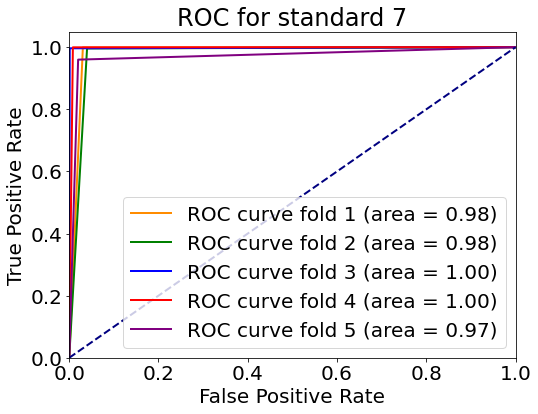

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_curve, auc

# 设置全局字体大小
plt.rcParams.update({'font.size': 20})  # 设置字体大小为 14
# 假设有模型的预测结果和真实标签
# 例如，假设模型预测的结果存储在名为 predicted_labels 的数组中，
# 真实标签存储在名为 true_labels 的数组中
# 将张量转换为 NumPy 数组
# predicted_labels = predicted_labels.cpu().numpy()
# true_labels = true_labels.cpu().numpy()

# # # 计算混淆矩阵
# conf_matrix = confusion_matrix(true_labels, predicted_labels)

# # 计算精确率和召回率
# # 注意：在这里，MCS 是标签 0，UWS 是标签 1
# precision = precision_score(true_labels, predicted_labels, labels=[0, 1], average=None)
# recall = recall_score(true_labels, predicted_labels, labels=[0, 1], average=None)

# # # 绘制混淆矩阵
# plt.figure(figsize=(10, 8))  # 设置图形大小
# plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
# plt.colorbar()

# # 标记轴和标签
# # classes = ['HC', 'DOC']
# classes = ['MCS', 'UWS']
# tick_marks = np.arange(len(classes))
# plt.xticks(tick_marks, classes, rotation=45)
# plt.yticks(tick_marks, classes)

# # 添加数值标签和精确率/召回率信息（保持字体大小一致）
# thresh = conf_matrix.max() / 2.
# for i in range(conf_matrix.shape[0]):
#     for j in range(conf_matrix.shape[1]):
#         if i == j:  # change the field of prec and rec
# #             plt.text(j, i, f'{conf_matrix[i, j]}\n\nPrec: {precision[j]:.2f}\nRec: {recall[i]:.2f}',
# #                      horizontalalignment="center",
# #                      verticalalignment="center",
# #                      color="white" if conf_matrix[i, j] > thresh else "black")
#             plt.text(j, i, f'{conf_matrix[i, j]}',
#                      horizontalalignment="center",
#                      verticalalignment="center",
#                      color="white" if conf_matrix[i, j] > thresh else "black")
#         else:
#             plt.text(j, i, f'{conf_matrix[i, j]}',
#                      horizontalalignment="center",
#                      verticalalignment="center",
#                      color="white" if conf_matrix[i, j] > thresh else "black")

# plt.tight_layout()
# plt.ylabel('True label')
# plt.xlabel('Predicted label')
# # plt.title('Confusion Matrix for HC/DOC')
# plt.title('Confusion Matrix for MCS/UWS')
# plt.show()

plt.figure(figsize=(8, 6))
colors = ['darkorange', 'green', 'blue', 'red', 'purple']
for fold in range(5):
    predicted_labels_fold = predicted_labels_list[fold].cpu().numpy()
    true_labels_fold = true_labels_list[fold].cpu().numpy()
    fpr, tpr, _ = roc_curve(true_labels_fold, predicted_labels_fold)  # 根据预测概率计算 ROC
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[fold], lw=2, label=f'ROC curve fold {fold+1} (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for standard 7')
plt.legend(loc='lower right')
plt.show()

# Draw Confusion Matrix

In [12]:
# ConditionB
# model.load_state_dict(torch.load(f"../model/{exper_dir}/Fold3_Epoch19.pt")) # !!!!!!!!!!!!!!!!!!!!!
# model.load_state_dict(torch.load(f"../model/{exper_dir}/Fold4_Epoch11.pt"))

# ConditionC
# model.load_state_dict(torch.load(f"../model/{exper_dir}/Fold0_Epoch19.pt"))
# model.load_state_dict(torch.load(f"../model/{exper_dir}/Fold1_Epoch28.pt"))
# model.load_state_dict(torch.load(f"../model/{exper_dir}/Fold2_Epoch27.pt"))
# model.load_state_dict(torch.load(f"../model/{exper_dir}/Fold3_Epoch50.pt"))
# 假设有模型的预测结果和真实标签
#例如，假设模型预测的结果存储在名为 predicted_labels 的张量中，
# 真实标签存储在名为 true_labels 的张量中
# predicted_labels = torch.tensor([0, 1, 2, 1, 0, 2])
# true_labels = torch.tensor([0, 1, 2, 1, 0, 1])

# 将张量转换为 NumPy 数组
predict_labels = predict_labels.cpu().numpy()
true_labels = true_labels.cpu().numpy()

# 计算混淆矩阵
conf_matrix = confusion_matrix(true_labels, predict_labels)

# 绘制混淆矩阵
plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
plt.colorbar()

# 标记轴和标签
classes = ['MCS', 'UWS']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# 添加数值标签
thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()


AttributeError: 'numpy.ndarray' object has no attribute 'cpu'